In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import inception_v3

In [2]:
base_model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

In [3]:
base_model.summary()

     activation_67[0][0]              
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (None, None, None, 1 147456      average_pooling2d_6[0][0]        
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, None, None, 1 576         conv2d_60[0][0]                  
__________________________________________________________________________________________________
batch_normalization_63 (BatchNo (None, None, None, 1 576         conv2d_63[0][0]                  
__________________________________________________________________________________________________
batch_normalization_68 (BatchNo (None, None, None, 1 576         conv2d_68[0][0]                  
__________________________________________________________________________________________________
batch_normalization_69 (BatchNo (None, None, None, 1 576         conv2

In [4]:
"""
depending on which layer you choose:

layer 1: wavy
layer 2: lines
layer 3: boxes
layer 4: circles?
layer 6: dogs, bears, cute animals.
layer 7: faces, buildings
layer 8: fish begin to appear, frogs/reptilian eyes.
layer 10: Monkies, lizards, snakes, duck

Choosing various parameters like num_iterations, rescale,
and num_repeats really varies on which layer you're doing.
"""

"\ndepending on which layer you choose:\n\nlayer 1: wavy\nlayer 2: lines\nlayer 3: boxes\nlayer 4: circles?\nlayer 6: dogs, bears, cute animals.\nlayer 7: faces, buildings\nlayer 8: fish begin to appear, frogs/reptilian eyes.\nlayer 10: Monkies, lizards, snakes, duck\n\nChoosing various parameters like num_iterations, rescale,\nand num_repeats really varies on which layer you're doing.\n"

In [5]:
layers = {
    "mixed4": 0,
    "mixed4": 0,
    "mixed5": 0,
    "mixed6": 0,
    "mixed7": 1,
}

num_octave = 3

octave_scale = 1.4

In [6]:
feat_op = dict([(layer.name, layer.output) for layer in [base_model.get_layer(name) for name in layers]])


feature_extractor = tf.keras.Model(inputs=base_model.inputs,
                                  outputs=feat_op)

In [7]:
def preprocess_image(image_path, base_module=inception_v3):
    img = tf.keras.preprocessing.image.load_img(image_path)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.expand_dims(img, axis=0)
    img = base_module.preprocess_input(img)
    
    return img

In [8]:
def deprocess_image(img):
    
    img = tf.reshape(img, (img.shape[1], img.shape[2], 3))
    
    img /= 2.0
    img += 0.5
    img *=255.0
    
    #img = np.clip(img, 0, 255).astype('uint8')
    img = tf.cast(tf.clip_by_value(img, 0, 255), tf.uint8)
        
    
    return img

In [9]:
proc = preprocess_image("sky.jpg")
plt.imshow(proc[0])

FileNotFoundError: [Errno 2] No such file or directory: 'sky.jpg'

In [ ]:
deproc = deprocess_image(proc)
plt.imshow(deproc)

## Calculating Loss

In [ ]:
def loss_fn(image, model):
    features = model(image)
    
    #print(features)    
    loss = tf.zeros(shape=())
    for layer in features.keys():
        coeff = layers[layer]
        activation = features[layer]
        scaling = tf.reduce_prod(tf.cast(tf.shape(activation), tf.float32))
        loss+=coeff*tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :]))/scaling
    return loss


In [ ]:
loss = loss_fn(processed_img, feature_extractor)

In [13]:
@tf.function
def _gradient_ascent(img, model:tf.keras.Model, step_size):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = loss_fn(img, model)
    grads = tape.gradient(loss, img)
    
    #Normalizing  gradients: Crucial
    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
    img += step_size * grads
    img = tf.clip_by_value(img, -1, 1)
    
    return loss, img

def gradient_ascent_loop(img, model, iterations, step_size, max_loss=None, save_every:int=0):
    for i in range(iterations):
        loss, img = _gradient_ascent(img, model, step_size)
        
        if save_every>0 and i%save_every==0:
            tf.keras.preprocessing.image.save_img(f"saves/dream_{img.shape[1]}_{img.shape[2]}_{i}" + ".png", deprocess_image(img))
            print(f"dream_{img.shape[1]}_{img.shape[2]}_{i}" + ".png")
        
        if max_loss and loss>max_loss:
            print("max loss reached")
            break
        print(f"loss value at step {i}: {loss}")
    return img

In [15]:
%%time
processed_img = preprocess_image("inputs/aus.jpg", inception_v3)

Wall time: 262 ms


In [16]:
processed_img = tf.image.resize(processed_img, (326, 489))

In [1]:
import os

In [15]:
import imageio

In [16]:
img_paths = os.listdir("saves")

In [19]:
images=[]
for i in range(len(img_paths)):
    images.append(imageio.imread(f"saves/dream_326_489_{i}.png"))

In [22]:
imageio.mimsave('a_dream.gif', images, fps=20)

In [25]:
if not os.path.isdir("saves"):
    try:
        os.mkdir("saves")
    except:
        print("couldn't create directory")


In [35]:

img = processed_img
iterations = 1000
step_size=0.01
save_every = 1

x_size = 0.5
y_size = 0.5

processed_img = preprocess_image("inputs/aus.jpg", inception_v3)
processed_img = tf.image.resize(processed_img, (int(processed_img.shape[1]/2), int(processed_img.shape[2]/2)))

In [38]:
processed_img.shape

TensorShape([1, 682, 1024, 3])

In [ ]:
for i in range(iterations):
    
    if os.path.isfile(f"saves/dream_{img.shape[1]}_{img.shape[2]}_{i}" + ".jpg"):
        print(f"saves/dream_{img.shape[1]}_{img.shape[2]}_{i}" + ".jpg Exist")
    else:
    
        img = tf.keras.preprocessing.image.load_img(f"saves/dream_{img.shape[1]}_{img.shape[2]}_{int(i-1)}" + ".jpg")
        img = tf.keras.preprocessing.image.img_to_array(img)

        x_trim = 2
        y_trim = 1

        print(img.shape)
        img = img[0+x_trim:x_size-x_trim, 0+y_trim:y_size-y_trim]
        print(img.shape)
        img = tf.image.resize(img, (x_size, y_size))
        print(img.shape)
        img = tf.expand_dims(img, axis=0)
        img = inception_v3.preprocess_input(img)

        img = gradient_ascent_loop(img, feature_extractor, 10, 0.01, max_loss=None, save_every=0)

        if save_every>0 and i%save_every==0:
            tf.keras.preprocessing.image.save_img(f"saves/dream_{img.shape[1]}_{img.shape[2]}_{i}" + ".jpg", deprocess_image(img))
            print(f"dream_{img.shape[1]}_{img.shape[2]}_{i}" + ".jpg")


In [ ]:
%%time
original_image = preprocess_image("aus.jpg")
original_shape = original_image.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tf.TensorShape(tuple([int(dim/(octave_scale**i)) for dim in original_shape]))
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
print(successive_shapes)

shrunk_original_img = tf.image.resize(original_image, successive_shapes[0])
#print(shrunk_original_img.shape)

img = tf.identity(original_image)

for i, shape in enumerate(successive_shapes):
    print(f"Processing octave {i} with shape {shape}")
    img = tf.image.resize(img, shape)
    
    
    img = gradient_ascent_loop(img, feature_extractor, 
                               iterations=20, step_size=0.01,max_loss=15)
    
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_image, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = tf.image.resize(original_image, shape)
    
#img = gradient_ascent_loop(processed_img, feature_extractor, 10, 0.01, max_loss=15)

In [574]:
tf.keras.preprocessing.image.save_img("dream" + ".png",deprocess_image(img))

In [575]:
from IPython.display import Image, display

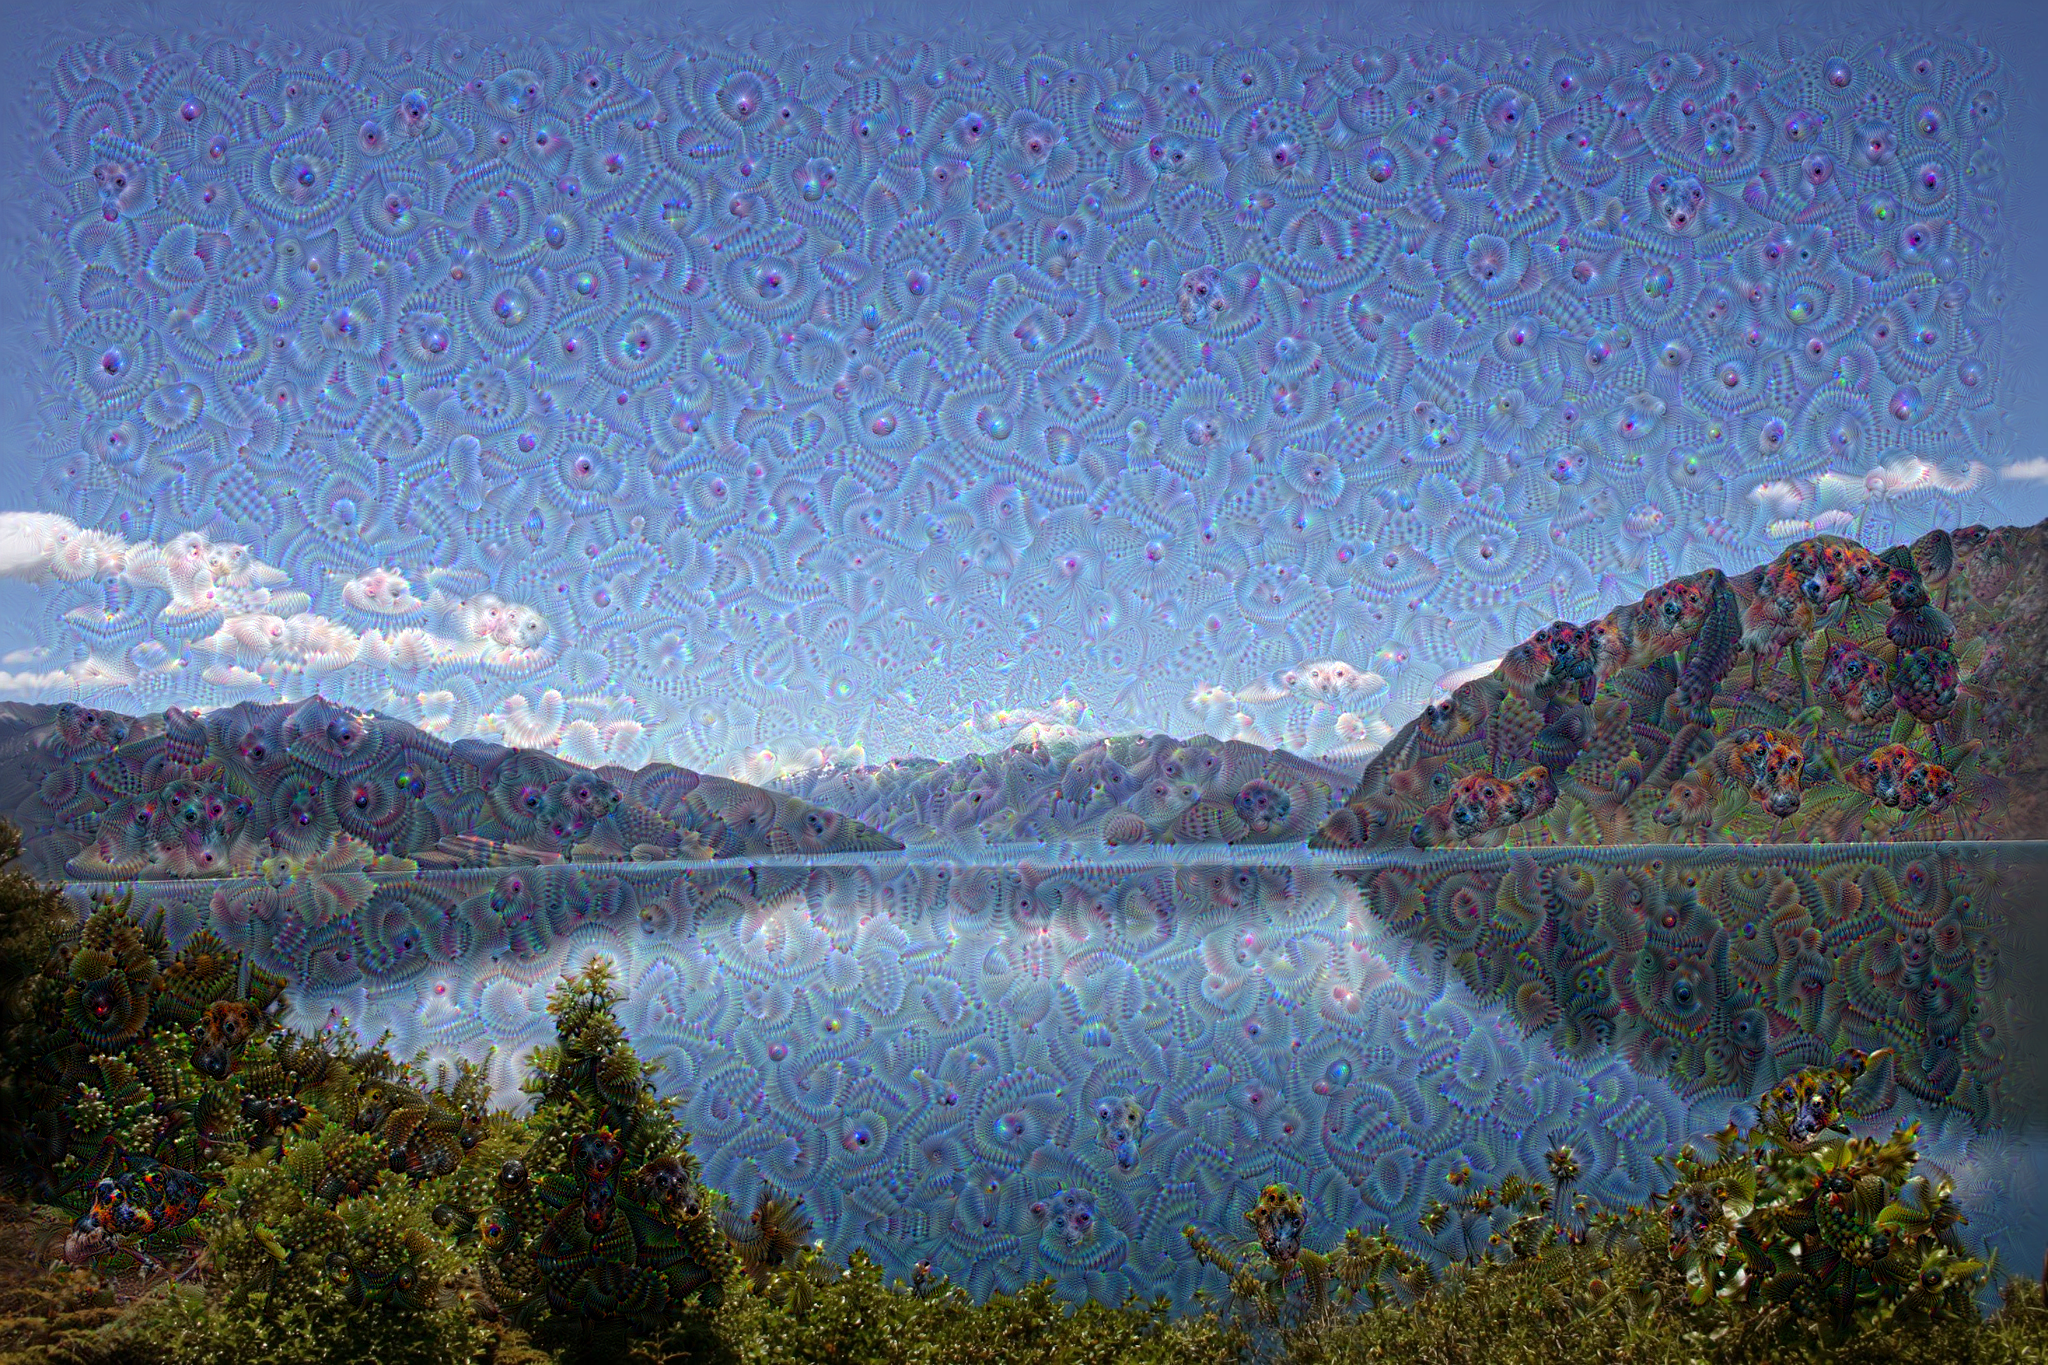

In [576]:
display(Image("dream.png"))